In [1]:
from astropy.io import fits
import numpy as np
import glob

In [2]:
data_dir = '../20200729/'

In [3]:
files = glob.glob(data_dir + '*opt00.bs.fits')  # Pre/over-scan region removed images (using hpkossub.py).

In [4]:
len(files)

180

In [5]:
def find_files_w_header(find_dict, fns):
    """ File name filtering using fits headers.
    """
    fns_result = []
    for fn in fns:
        hdul = fits.open(fn)
        found = True
        for key in find_dict:
            if hdul[0].header[key] != find_dict[key]:
                found = False
                break
        if found == True:
            fns_result.append(fn)
    return fns_result

In [6]:
# Filter for test images for gain measurment.
find_dict={
    'OBJECT':  'SpecFlat', 
    'WH_OPTF1': 'grism Opt', 
    'WH_OPTF2': 'none',
    'OBS-MODE': 'Spec20',
}

In [7]:
fns_testimgs_bs = find_files_w_header(find_dict, files)

In [8]:
len(fns_testimgs_bs)

40

In [9]:
# Filter for bias images.
find_bias={
    'OBJECT': 'BIAS',
    'CCD-MODE': 'Full',
}

In [10]:
fns_bias = find_files_w_header(find_bias, files)

In [11]:
len(fns_bias)

10

In [12]:
bias_imgs = []
for fn in fns_bias:
    hdul = fits.open(fn)
    bias_imgs.append(hdul[0].data)
bias_imgs_ndarray = np.stack(bias_imgs)

In [13]:
bias_img_median = np.median(bias_imgs_ndarray, axis=0)
del(bias_imgs)

In [14]:
import matplotlib.pyplot as plt

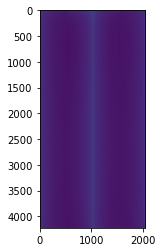

In [15]:
plt.imshow(bias_img_median)

In [16]:
imgs_testimgs_bs = []
for fn in fns_testimgs_bs:
    hdul = fits.open(fn)
    imgs_testimgs_bs.append(hdul[0].data - bias_img_median)

In [17]:
imgs_testimgs_bs_ndarray = np.stack(imgs_testimgs_bs)
del(imgs_testimgs_bs)

In [18]:
testimg_bs_median = np.median(imgs_testimgs_bs_ndarray, axis=0)

In [19]:
testimg_bs_std = np.std(imgs_testimgs_bs_ndarray, axis=0)

In [20]:
img_ave = np.average(testimg_bs_median)
img_std = np.average(testimg_bs_std)

In [21]:
testimg_bs_median.shape

(4222, 2048)

In [22]:
np.max(testimg_bs_median)

34194.97

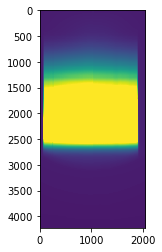

In [23]:
plt.imshow(testimg_bs_median, vmin=-1000, vmax = img_ave*2)

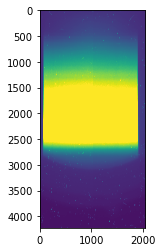

In [24]:
plt.imshow(testimg_bs_std, vmin=0, vmax=img_std*2)

In [25]:
testimg_bs_dev = testimg_bs_std **2

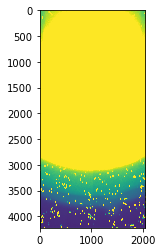

In [26]:
plt.imshow(testimg_bs_dev, vmin=0, vmax=100)

In [27]:
img_ysize = testimg_bs_median.shape[0]

In [28]:
img_xsize = testimg_bs_median.shape[1]

In [29]:
img_xsize_per_ch = int(img_xsize /2)

In [30]:
print(img_xsize, img_ysize, img_xsize_per_ch)

2048 4222 1024


In [31]:
sample_xwidth_per_ch = 256

In [32]:
def get_sample_regions(imgdata, n_port, img_xsize_per_ch, sample_xsize_per_ch):
    """
    n_port: 1-4
    """
    n_ch = n_port -1
    xmin = img_xsize_per_ch * n_ch +int(img_xsize_per_ch/2) - int(sample_xsize_per_ch/2)
    xmax =  img_xsize_per_ch * n_ch +int(img_xsize_per_ch/2) + int(sample_xsize_per_ch/2)
    return imgdata[:, xmin:xmax+1]

In [33]:
n_port = 1

In [34]:
array_sig = get_sample_regions(testimg_bs_median, n_port, img_xsize_per_ch, sample_xwidth_per_ch).ravel()
array_dev = get_sample_regions(testimg_bs_dev, n_port, img_xsize_per_ch, sample_xwidth_per_ch).ravel()

In [35]:
array_sig.shape

(1085054,)

In [36]:
array_dev.shape

(1085054,)

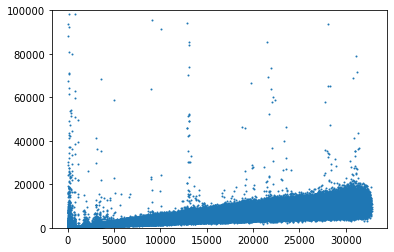

In [37]:
plt.ylim([0, 100000])
plt.scatter(array_sig, array_dev, s=1)

In [38]:
x_bin_width = 100

In [39]:
np.max(array_sig)

32827.977

In [40]:
x_max_calc = np.floor(np.max(array_sig)/x_bin_width-1)*x_bin_width

In [41]:
x_max_calc

32700.0

In [42]:
sig_all = []
dev_all = []
err_all = []
x = 0
while (x<= x_max_calc):
    #print(x)
    data_index = ((array_sig > x) & (array_sig <= x+x_bin_width))
    x += x_bin_width
    #print(data_index)
    #and array_sig <= (x+x_bin_width))
    sig_data_prt = array_sig[data_index]
    dev_data_prt = array_dev[data_index]
    
    trues = data_index[data_index==True]
    n_sample = len(trues)
    if n_sample == 0:
        continue
    sig = np.median(sig_data_prt)
    dev = np.median(dev_data_prt)
    error = np.std(dev_data_prt)/np.sqrt(n_sample-1)
    print(sig, dev, error, n_sample)
    sig_all.append(sig)
    dev_all.append(dev)
    err_all.append(error)

18.648174 15.429771 4.856968275101542 169724
161.3504 59.88388 4.892485727110934 103336
256.14667 94.85553 1.6468024615810777 72090
349.16296 130.62149 2.0233002036364263 50386
444.05206 164.68979 4.804778270029639 33728
542.46594 198.41159 1.9127370828318637 21099
644.19995 234.58102 1.88584605845635 12577
749.1056 272.85748 0.9523382161850728 12447
848.54645 310.0069 27.955184609645315 11708
948.19617 344.05344 0.8241025108939278 9594
1048.8958 380.1056 0.9731492494455442 8764
1147.4573 415.01782 10.554521728489297 7507
1249.6285 449.69037 1.3260598837482518 6458
1351.5343 488.27734 1.3694352985358769 6891
1449.8569 525.03503 1.3885331862721186 7433
1548.1627 564.7175 1.6081147785894143 6660
1647.5303 595.2016 1.9253181334641543 5449
1749.8142 631.3165 5.174980100686266 4661
1850.1387 672.6003 3.829380919303127 4764
1949.6816 705.5684 3.6104681517047923 4773
2048.718 740.3145 2.968357240111979 4586
2148.12 776.9243 3.7746683091999063 3999
2248.4773 810.3057 7.797189068457237 3685
234

19350.047 6547.8276 31.142879367122518 2265
19448.957 6471.339 32.207721342575944 2172
19551.047 6573.891 34.04426425715576 2058
19651.031 6636.26 34.86763662844315 2015
19749.77 6627.8037 33.59806287167835 2063
19850.299 6719.536 47.11155550095665 2042
19950.148 6670.6777 40.037538960756194 1849
20048.137 6759.105 69.27034929834282 1667
20146.357 6718.088 119.0487124794408 1445
20246.242 6720.6323 47.620047359327486 1101
20349.299 6822.983 47.319201937424 1017
20449.719 6798.8613 47.863604556231344 1034
20552.352 6892.9053 48.27922519353062 1049
20651.426 6855.0586 45.359082132386945 1218
20752.637 6942.052 43.95589806945727 1254
20850.965 6864.921 44.15999652014787 1412
20951.229 7002.88 42.029270536549454 1397
21048.652 6973.617 41.297661871147305 1480
21150.8 6938.376 40.96771602554714 1598
21248.297 7018.1816 40.3758821447131 1694
21349.93 7010.7793 39.96452830739325 1728
21452.41 7050.4487 57.53173098320416 1848
21550.895 7122.938 38.865780682624326 1921
21650.418 7181.0044 58.44

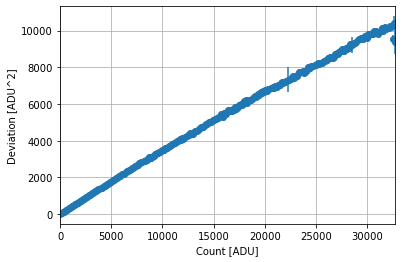

In [43]:
plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt="o")
plt.grid()
plt.xlabel('Count [ADU]')
plt.ylabel('Deviation [ADU^2]')
plt.xlim([0, x_max_calc])
plt.show()

In [44]:
from scipy import optimize

In [45]:
def photontransfer_curve(x, gain, ro):
    return x/gain + (ro/gain)**2

In [46]:
par, cov = optimize.curve_fit(photontransfer_curve, sig_all, dev_all,  sigma=err_all, p0=(0.1, 4.0))

In [47]:
par

array([ 2.98793223, 17.8188298 ])

In [48]:
cov

array([[4.25753512e-05, 2.24375912e-03],
       [2.24375912e-03, 3.38601916e-01]])

In [49]:
x_fit = np.linspace(0, 25000, 26)

In [50]:
y_fit = photontransfer_curve(x_fit, par[0], par[1])

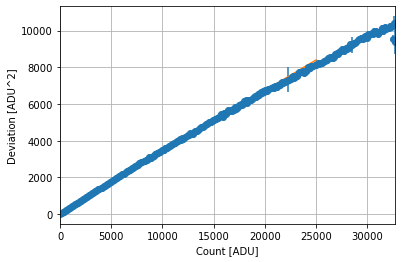

In [51]:
plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt="o")
plt.plot(x_fit, y_fit)
plt.grid()
plt.xlabel('Count [ADU]')
plt.ylabel('Deviation [ADU^2]')
plt.xlim([0, x_max_calc])
plt.show()

In [52]:
def analyse_photontransfer_curve(sig_all, dev_all, err_all, p0=(3, 10.0)):
    par, cov = optimize.curve_fit(photontransfer_curve, sig_all, dev_all,  sigma=err_all, p0=p0, absolute_sigma=False)
    return par, cov

In [53]:
def plt_photontransfer_curve(sig_all, dev_all, err_all, par):
    x_fit = np.linspace(0, np.max(sig_all)*0.8, 100)
    y_fit = photontransfer_curve(x_fit, par[0], par[1])
    plt.grid()
    plt.xlabel('Count [ADU]')
    plt.ylabel('Deviation [ADU^2]')
    plt.xlim([0, x_max_calc])
    plt.ylim([0,10000])
    plt.errorbar(sig_all, dev_all, yerr=err_all,  fmt=".")
    plt.plot(x_fit, y_fit, color='r', linewidth=3)
    plt.show()

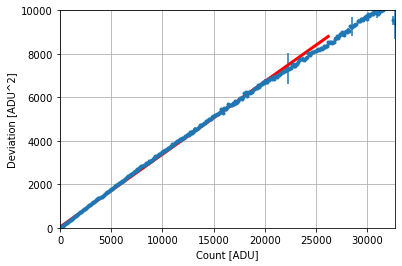

In [54]:
par, cov = analyse_photontransfer_curve(sig_all, dev_all, err_all)
plt_photontransfer_curve(sig_all, dev_all, err_all, par)

In [55]:
def get_sample_region(img_sig, img_dev, n_port, sample_xsize_per_ch=256):
    img = img_sig
    img_ysize = img.shape[0]
    img_xsize = img.shape[1]
    img_xsize_per_ch = int(img_xsize /4)
    n_ch = n_port -1
    xmin = int(img_xsize_per_ch * n_ch + img_xsize_per_ch/2 - sample_xsize_per_ch/2)
    xmax =  int(img_xsize_per_ch * n_ch + img_xsize_per_ch/2 + sample_xsize_per_ch/2)
    print('img_sig.shape {}'.format(img_sig.shape))
    print(xmin, xmax)
    array_sig = img_sig[:, xmin:xmax+1].ravel()
    array_dev= img_dev[:, xmin:xmax+1].ravel()
    return array_sig, array_dev

In [56]:
def calc_statistics_in_sample_region(array_sig, array_dev, count_bin_width=100):
    sig_all = []
    dev_all = []
    err_all = []
    count = 0
    count_max_calc = np.floor(np.max(array_sig)/count_bin_width-1)*count_bin_width
    while (count<= count_max_calc):
        #print(x)
        data_index = ((array_sig > count) & (array_sig <= count+count_bin_width))
        count += count_bin_width
        #print(data_index)
        #and array_sig <= (x+x_bin_width))
        sig_data_prt = array_sig[data_index]
        dev_data_prt = array_dev[data_index]
    
        trues = data_index[data_index==True]
        n_sample = len(trues)
        #print(n_sample)
        if n_sample == 0:
            continue
        sig = np.median(sig_data_prt)
        dev = np.median(dev_data_prt)
        error = np.std(dev_data_prt)/np.sqrt(n_sample-1)
       # print(sig, dev, error, n_sample)
        sig_all.append(sig)
        dev_all.append(dev)
        err_all.append(error)
    return sig_all, dev_all, err_all

## Calculate gains of the port 1-4

Port 1
img_sig.shape (4222, 2048)
128 384


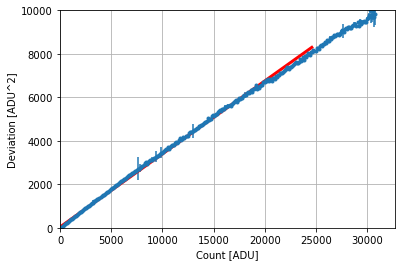

Port 2
img_sig.shape (4222, 2048)
640 896


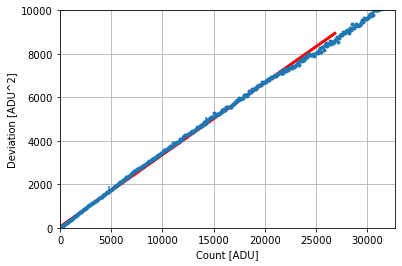

Port 3
img_sig.shape (4222, 2048)
1152 1408


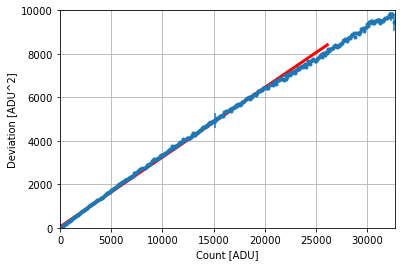

Port 4
img_sig.shape (4222, 2048)
1664 1920


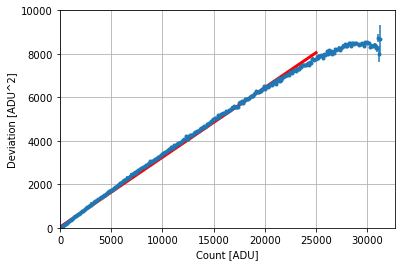

In [57]:
pars = []
covs = []
for n_port in range(1, 5):
    del(array_dev)
    del(array_sig)
    print('Port {}'.format(n_port))
    array_sig, array_dev = get_sample_region(testimg_bs_median, testimg_bs_dev, n_port)
    sig_all, dev_all, err_all = calc_statistics_in_sample_region(array_sig, array_dev)
    par, cov = analyse_photontransfer_curve(sig_all, dev_all, err_all)
    plt_photontransfer_curve(sig_all, dev_all, err_all, par)
    pars.append(par)
    covs.append(cov)

In [58]:
pars

[array([ 2.97688314, 18.41247375]),
 array([ 3.01723351, 20.6522781 ]),
 array([ 3.11814005, 20.22161818]),
 array([ 3.11847151, 18.77880369])]

In [59]:
covs

[array([[3.49360347e-05, 2.01235606e-03],
        [2.01235606e-03, 3.14087554e-01]]),
 array([[4.69697831e-05, 2.86655460e-03],
        [2.86655460e-03, 5.29943398e-01]]),
 array([[5.73587016e-05, 2.79341467e-03],
        [2.79341467e-03, 3.37345611e-01]]),
 array([[1.25970398e-04, 5.08975032e-03],
        [5.08975032e-03, 7.79099945e-01]])]

In [60]:
i=1
print('#ch gain [e/ADU] err_gain ro[e-] err_ro')
for par, cov in zip(pars, covs):
    print('{:1d} {:12.5f} {:12.5f} {:8.2f} {:8.2f}'.format(i, float(par[0]),  float(cov[0][1]), float(par[1]), float(cov[1][1])))
    i += 1

#ch gain [e/ADU] err_gain ro[e-] err_ro
1      2.97688      0.00201    18.41     0.31
2      3.01723      0.00287    20.65     0.53
3      3.11814      0.00279    20.22     0.34
4      3.11847      0.00509    18.78     0.78
